In [1]:
import clustering_predict

age = 30
cp_status = '나홀로 여행'
cp_num = 2
day = 1
purpose = '단순 구경 / 산책 / 걷기'
traffic = '항공기'
cluster = clustering_predict.cluster_predict(age, cp_num, cp_status, day, purpose, traffic)
print(f"새로운 사용자는 {cluster}번 군집에 속합니다.")

새로운 사용자는 1번 군집에 속합니다.


Tkinter GUI

In [3]:
import tkinter as tk
from tkinter import ttk
from cluster_input import cluster_predict, load_data_and_model
import pandas as pd
import os

# 동행 형태와 동행자 수 매핑
COMPANION_MAP = {   
    "2인 여행(가족 외)": 2,
    "3인 이상 여행(가족 외)": 3
}

# CSV 파일 경로
INPUTS_FILE = "user_inputs.csv"

# 이전 입력값 불러오기
def load_previous_inputs():
    if os.path.exists(INPUTS_FILE):
        try:
            return pd.read_csv(INPUTS_FILE).iloc[-1].to_dict()  # 마지막 입력값 불러오기
        except Exception as e:
            print(f"입력값 로드 중 오류 발생: {e}")
    return {}  # 입력값이 없거나 파일이 없으면 빈 딕셔너리 반환

# 나이를 숫자 연령대로 변환하는 함수
def age_to_age_grp(age):
    """
    나이를 10, 20, 30 등 숫자 범주의 연령대로 변환
    """
    if age < 20:
        return 10
    elif age < 30:
        return 20
    elif age < 40:
        return 30
    elif age < 50:
        return 40
    elif age < 60:
        return 50
    else:
        return 60

# Tkinter GUI 만들기
def main_gui():
    # 모델과 데이터 로드
    try:
        df_cluster, kmeans_model, model_features = load_data_and_model()  # 반환값 3개로 수정
    except Exception as e:
        print(f"데이터 및 모델 로드 실패: {e}")
        return

    # 입력값 저장용 리스트
    input_data = []

    # 이전 입력값 로드
    previous_inputs = load_previous_inputs()

    root = tk.Tk()
    root.title("여행 클러스터 예측")

    # 입력 필드: 나이
    tk.Label(root, text="나이:").grid(row=0, column=0, padx=10, pady=5)
    age_entry = tk.Entry(root)
    age_entry.grid(row=0, column=1, padx=10, pady=5)
    age_entry.insert(0, previous_inputs.get("나이", ""))  # 이전 값 채우기

    # 입력 필드: 동행자 형태
    tk.Label(root, text="동행자 형태:").grid(row=1, column=0, padx=10, pady=5)
    cp_status_combo = ttk.Combobox(root, values=list(COMPANION_MAP.keys()) + ["자녀 동반 여행"])
    cp_status_combo.grid(row=1, column=1, padx=10, pady=5)
    cp_status_combo.set(previous_inputs.get("동행자 형태", ""))  # 이전 값 채우기

    # 입력 필드: 동행자 수
    tk.Label(root, text="동행자 수:").grid(row=2, column=0, padx=10, pady=5)
    cp_num_entry = tk.Entry(root)
    cp_num_entry.grid(row=2, column=1, padx=10, pady=5)
    cp_num_entry.insert(0, previous_inputs.get("동행자 수", ""))  # 이전 값 채우기

    # 동행 형태 선택 시 자동으로 동행자 수 채우기
    def on_cp_status_selected(event):
        selected_status = cp_status_combo.get()
        if selected_status in COMPANION_MAP:
            cp_num_entry.delete(0, tk.END)
            cp_num_entry.insert(0, COMPANION_MAP[selected_status])
        else:
            cp_num_entry.delete(0, tk.END)

    cp_status_combo.bind("<<ComboboxSelected>>", on_cp_status_selected)

    # 숙박 일수 선택
    tk.Label(root, text="숙박 일수:").grid(row=3, column=0, padx=10, pady=5)
    sleep_combo = ttk.Entry(root)
    sleep_combo.grid(row=3, column=1, padx=10, pady=5)
    sleep_combo.insert(0, previous_inputs.get("숙박 일수", ""))  # 이전 값 채우기

    # 이동 수단 선택
    tk.Label(root, text="이동 수단:").grid(row=4, column=0, padx=10, pady=5)
    traffic_combo = ttk.Combobox(root, values=["자가용", "대중교통", "항공기"])
    traffic_combo.grid(row=4, column=1, padx=10, pady=5)
    traffic_combo.set(previous_inputs.get("이동 수단", ""))  # 이전 값 채우기

    # 여행 목적 체크박스
    tk.Label(root, text="여행 목적:").grid(row=5, column=0, padx=10, pady=5)
    purpose_frame = tk.Frame(root)
    purpose_frame.grid(row=5, column=1, padx=10, pady=5)
    purposes = ["체험 활동", "단순 구경 / 산책", "휴식"]
    selected_purposes = []

    def toggle_purpose(purpose):
        if purpose in selected_purposes:
            selected_purposes.remove(purpose)
        else:
            selected_purposes.append(purpose)

    # 이전 목적값 체크박스 선택
    previous_purposes = previous_inputs.get("여행 목적", "").split(", ")
    for purpose in purposes:
        var = tk.BooleanVar(value=purpose in previous_purposes)
        tk.Checkbutton(
            purpose_frame, text=purpose, variable=var,
            command=lambda p=purpose: toggle_purpose(p)
        ).pack(side="left", padx=5)
        if var.get():
            selected_purposes.append(purpose)

    # 실행 버튼
    predict_button = tk.Button(root, text="실행", command=lambda: predict_cluster())
    predict_button.grid(row=6, column=0, columnspan=2, pady=10)

    # 결과 출력 레이블을 미리 생성
    result_label_cluster = tk.Label(root, text="클러스터: ", justify="left")
    result_label_cluster.grid(row=7, column=0, columnspan=2, padx=10, pady=5)

    result_label_region = tk.Label(root, text="시군구: ", justify="left")
    result_label_region.grid(row=8, column=0, columnspan=2, padx=10, pady=5)

    # lkm 실행에 결과에 따른 클러스터 정보 저장 
    id_clutster = pd.DataFrame()
    #필요한 원본 데이터 불러다가 저장 
    df_tv = pd.read_csv('tn_travel_여행.csv')
    df_tm = pd.read_csv('tn_traveller_master_여행객 Master.csv')
    # Test label
    Test_label = tk.Label(root, text="시험 가동", justify="left")
    Test_label.grid(row=9, column=0, columnspan=2, pady=10)

    # 실행 버튼 클릭 시 동작
    def predict_cluster():
        age = age_entry.get()
        cp_status = cp_status_combo.get()
        cp_num = cp_num_entry.get()
        day = sleep_combo.get()
        traffic = traffic_combo.get()

        if all([age, cp_status, cp_num, day, selected_purposes, traffic]):
            try:
                # 나이를 숫자 연령대로 변환
                age_grp = age_to_age_grp(int(age))

                cluster = cluster_predict(age_grp, int(cp_num), cp_status, int(day), selected_purposes, traffic)
                
                # 결과 레이블 갱신
                result_label_cluster.config(text=f"클러스터: {cluster}")
                result_label_region.config(text=f"시군구: 없음")  # 현재 위치 제거했으므로 시군구는 고정값 없음

                # 입력값 저장
                input_data.append({
                    "나이": age,
                    "동행자 형태": cp_status,
                    "동행자 수": cp_num,
                    "숙박 일수": day,
                    "이동 수단": traffic,
                    "여행 목적": ', '.join(selected_purposes),
                    "클러스터": cluster
                })
                
                # 클러스터 번호에 따른 데이터 로드 
                id_clutster['TRAVEL_ID'] = df_cluster[df_cluster['Cluster'] == cluster]['TRAVEL_ID']
                Test_label.config(text=f"{id_clutster['TRAVEL_ID'].__len__()} in Cluster : {cluster}")

            except Exception as e:
                result_label_cluster.config(text=f"오류: {str(e)}")
                result_label_region.config(text="")
        else:
            result_label_cluster.config(text="모든 입력 필드를 채워주세요.")
            result_label_region.config(text="")

    # 종료 시 입력값 저장
    def on_close():
        if input_data:
            df = pd.DataFrame(input_data)
            df.to_csv(INPUTS_FILE, index=False, encoding="utf-8-sig")
            print(f"입력값이 '{INPUTS_FILE}'에 저장되었습니다.")
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_close)
    root.mainloop()

# 메인 실행
if __name__ == "__main__":
    main_gui()  # GUI 실행

입력값이 'user_inputs.csv'에 저장되었습니다.


In [4]:
main_gui()

입력값이 'user_inputs.csv'에 저장되었습니다.


In [58]:
df_cluster, kmeans_model, model_features = load_data_and_model()

centroids = kmeans_model.cluster_centers_

from scipy.spatial.distance import cdist
# 클러스터 중심 간 거리 계산 (유클리디안 거리)
distances = cdist(centroids, centroids, metric='euclidean')
distances

array([[0.        , 4.53654052, 4.98519692, 4.34860055, 3.50071398,
        3.80558756, 3.49903226, 4.80200326, 4.01348387],
       [4.53654052, 0.        , 2.08174747, 1.81774177, 2.89155348,
        2.05009565, 2.04496025, 1.62450509, 1.91895299],
       [4.98519692, 2.08174747, 0.        , 1.60169085, 2.57486002,
        1.75164233, 3.1403496 , 3.64681384, 1.67434465],
       [4.34860055, 1.81774177, 1.60169085, 0.        , 2.55561927,
        1.35787558, 2.91054972, 3.26380283, 1.16241821],
       [3.50071398, 2.89155348, 2.57486002, 2.55561927, 0.        ,
        1.64160107, 1.990536  , 3.85598371, 2.23035924],
       [3.80558756, 2.05009565, 1.75164233, 1.35787558, 1.64160107,
        0.        , 2.34411971, 3.3807002 , 1.04666776],
       [3.49903226, 2.04496025, 3.1403496 , 2.91054972, 1.990536  ,
        2.34411971, 0.        , 2.18774788, 2.70276628],
       [4.80200326, 1.62450509, 3.64681384, 3.26380283, 3.85598371,
        3.3807002 , 2.18774788, 0.        , 3.34945316],


In [59]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(centroids)

array([[ 1.00000000e+00, -1.96760829e-01, -5.02738076e-01,
        -2.08203956e-01,  4.31759325e-01,  2.18632510e-01,
         4.41490447e-01,  2.63689867e-02,  1.08390611e-01],
       [-1.96760829e-01,  1.00000000e+00,  2.78362060e-01,
         3.10135504e-01, -2.79782647e-01,  9.41842424e-02,
         4.46732032e-01,  8.86983656e-01,  3.15170165e-01],
       [-5.02738076e-01,  2.78362060e-01,  1.00000000e+00,
         4.84590532e-01,  3.63176982e-04,  3.65119167e-01,
        -3.16405280e-01, -1.55069886e-01,  4.89624979e-01],
       [-2.08203956e-01,  3.10135504e-01,  4.84590532e-01,
         1.00000000e+00, -2.35230050e-01,  4.62495103e-01,
        -3.96974707e-01, -2.95073175e-02,  6.84341386e-01],
       [ 4.31759325e-01, -2.79782647e-01,  3.63176982e-04,
        -2.35230050e-01,  1.00000000e+00,  5.22698647e-01,
         5.11489810e-01, -2.35909542e-01,  1.73089926e-01],
       [ 2.18632510e-01,  9.41842424e-02,  3.65119167e-01,
         4.62495103e-01,  5.22698647e-01,  1.000000

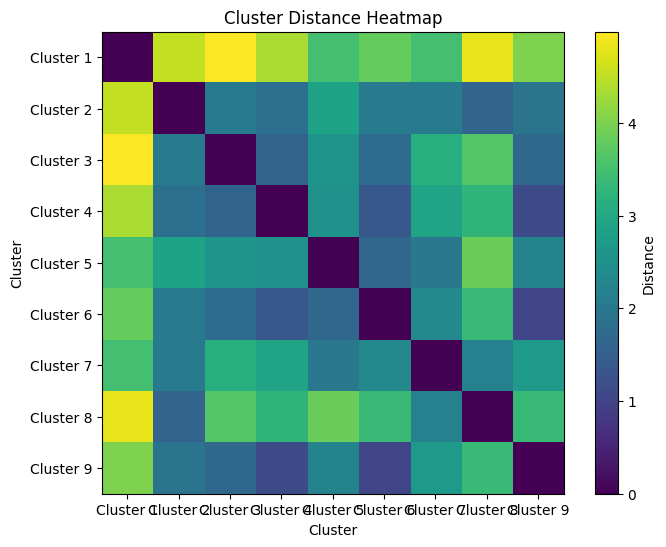

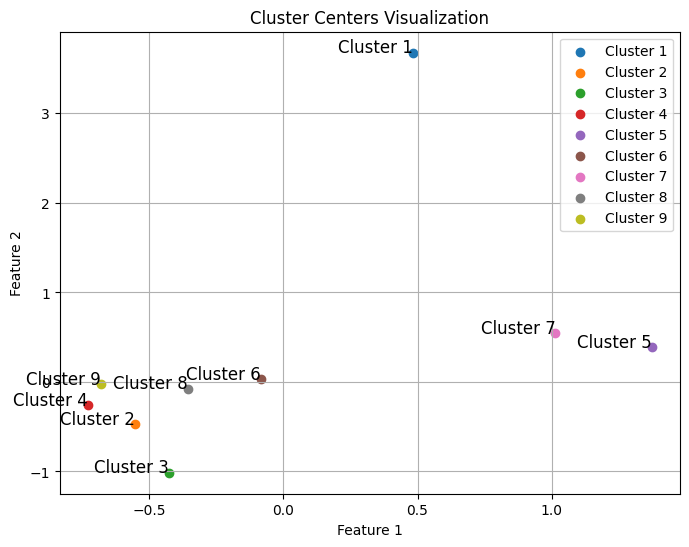

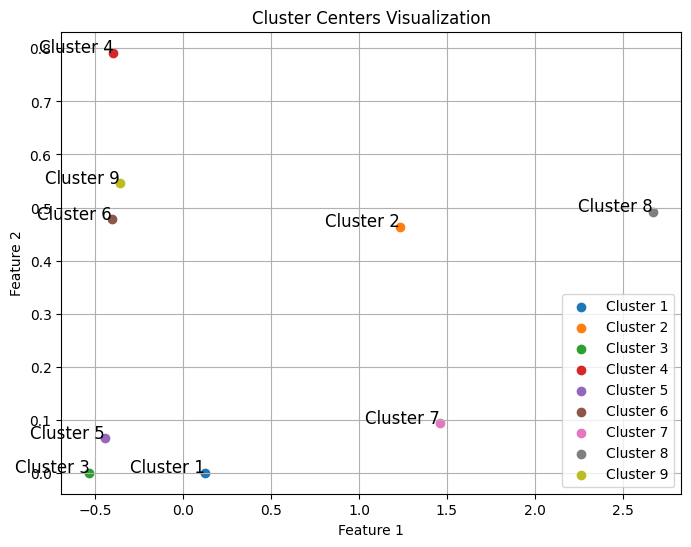

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

cluster_centers = kmeans_model.cluster_centers_ 

# Calculate pairwise Euclidean distances between cluster centers
distances = euclidean_distances(cluster_centers)

# Convert to a DataFrame for easier visualization and interpretation
distance_df = pd.DataFrame(distances, columns=[f"Cluster {i+1}" for i in range(len(cluster_centers))],
                           index=[f"Cluster {i+1}" for i in range(len(cluster_centers))])

# Display distance matrix
display(name="Cluster Distance Matrix", dataframe=distance_df)

# Plot heatmap for distance matrix
plt.figure(figsize=(8, 6))
plt.imshow(distances, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Distance")
plt.xticks(range(len(cluster_centers)), [f"Cluster {i+1}" for i in range(len(cluster_centers))])
plt.yticks(range(len(cluster_centers)), [f"Cluster {i+1}" for i in range(len(cluster_centers))])
plt.title("Cluster Distance Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

# Scatter plot to visualize cluster centers
plt.figure(figsize=(8, 6))
for idx, center in enumerate(cluster_centers):
    plt.scatter(center[0], center[1], label=f"Cluster {idx+1}")
    plt.text(center[0], center[1], f"Cluster {idx+1}", fontsize=12, ha='right')

plt.title("Cluster Centers Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

In [63]:
cluster_centers[0]

array([ 4.81978903e-01,  3.67685754e+00,  1.23601032e-01,  5.55111512e-17,
        2.54285714e-01,  0.00000000e+00,  5.17142857e-01, -5.55111512e-17,
        1.25714286e-01,  1.02857143e-01,  3.11428571e-01,  8.57142857e-02,
        6.28571429e-02,  3.14285714e-01,  2.25714286e-01,  2.85714286e-03,
        2.85714286e-03,  4.06575815e-20,  4.06575815e-20,  4.00000000e-02,
        2.85714286e-03,  1.14285714e-02, -6.93889390e-18,  1.71428571e-02,
        7.82857143e-01,  3.25260652e-19,  5.71428571e-03,  2.85714286e-03,
        1.14285714e-02,  6.85714286e-02])

In [1]:
import pandas as pd
import pickle
import os
from sklearn.preprocessing import StandardScaler
from kmodes import kprototypes

# 파일 경로 설정
MODEL_FILE = './cluster_model.pkl'
CLUSTER_FILE = './temp_clutster.csv'

# 데이터 및 모델 로드 함수
def load_data_and_model():
    """
    temp_clutster.csv와 kmeans_model.pkl 파일을 로드합니다.
    """
    if os.path.exists(CLUSTER_FILE) and os.path.exists(MODEL_FILE):
        try:
            # CSV 파일 읽기 (utf-8-sig 인코딩)
            df_cluster = pd.read_csv(CLUSTER_FILE, encoding='utf-8-sig')
        except UnicodeDecodeError:
            try:
                # 만약 utf-8-sig가 실패하면 cp949로 시도
                df_cluster = pd.read_csv(CLUSTER_FILE, encoding='cp949')
            except Exception as e:
                raise ValueError(f"CSV 파일 읽기 중 문제가 발생했습니다: {e}")

        try:
            # Pickle로 모델 로드
            with open(MODEL_FILE, 'rb') as f:
                model = pickle.load(f)
            # 모델에서 학습된 피처 이름 가져오기
            model_features = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else None

        except Exception as e:
            raise ValueError(f"모델 로드 중 오류 발생: {e}")
        
        return df_cluster, model, model_features
    else:
        raise FileNotFoundError("필요한 파일이 누락되었습니다: CSV 또는 모델 파일")

# 데이터 전처리 함수
def preprocessing_dataframe(df, model_features):
    """
    입력 데이터를 학습된 데이터와 동일한 형태로 전처리합니다.
    """
    ## 범주형 데이터를 원-핫 인코딩
    #df = pd.get_dummies(df)

    # # 학습된 피처 이름 기준으로 정렬 및 누락된 피처 추가
    # for feature in model_features:
    #     if feature not in df.columns:
    #         df[feature] = 0  # 누락된 피처를 기본값 0으로 추가
    # df = df[model_features]

    # 정규화 수행
    numeric_features = ['AGE_GRP', 'TRAVEL_COMPANIONS_NUM', 'SLEEP']
    if all(col in df.columns for col in numeric_features):
        scaler = StandardScaler()
        df[numeric_features] = scaler.fit_transform(df[numeric_features])

    return df

# 클러스터 예측 함수
def cluster_predict(age_grp, cp_num, cp_status, day, purpose, traffic):
    """
    입력 데이터를 받아 클러스터를 예측합니다.
    """

    # 입력값을 데이터프레임 형태로 준비
    input_data = pd.DataFrame({
        'AGE_GRP': [age_grp],
        'TRAVEL_COMPANIONS_NUM': [cp_num],
        'TRAVEL_STATUS_ACCOMPANY': [cp_status],
        'SLEEP': [day],
        'ACTIVITY': [', '.join(purpose) if isinstance(purpose, list) else purpose],
        'RESULT_MVMN': [traffic]
    })
    
    # 데이터 및 모델 로드
    df_cluster, model, model_features = load_data_and_model()

    # ACTIVITY 컬럼을 문자열 형태로 변환
    df_cluster['ACTIVITY'] = df_cluster['ACTIVITY'].apply(
        lambda x: ', '.join(x) if isinstance(x, list) else x
    )

    # 기존 데이터와 입력 데이터를 병합
    try:
        combined_data = pd.concat([df_cluster.drop(columns=['TRAVEL_ID', 'Cluster']), input_data], ignore_index=True)
    except KeyError as e:
        raise KeyError(f"데이터 병합 중 오류 발생: {e}")

    # 데이터 전처리
    preprocessed_data = preprocessing_dataframe(combined_data, model_features)

    # 클러스터 예측
    try:
        categorical_indices = [preprocessed_data.columns.get_loc(col) for col in preprocessed_data.select_dtypes(include=['object', 'category']).columns]
        predicted_cluster = model.predict(preprocessed_data.tail(1), categorical=categorical_indices)
    except ValueError as e:
        raise ValueError(f"클러스터 예측 중 오류 발생: {e}")
    return predicted_cluster

In [2]:
age = 30
cp_status = '나홀로 여행'
cp_num = 2
day = 1
purpose = '단순 구경 / 산책 / 걷기'
traffic = '항공기'
cluster = cluster_predict(age, cp_num, cp_status, day, purpose, traffic)
print(f"새로운 사용자는 {cluster}번 군집에 속합니다.")

새로운 사용자는 [5]번 군집에 속합니다.


In [13]:
df_cluster, kmeans_model, model_features = load_data_and_model()
id_clutster = pd.DataFrame()
cluster
#id_clutster['TRAVEL_ID'] = df_cluster[df_cluster['Cluster']==cluster]['TRAVEL_ID']
#id_clutster['TRAVEL_ID'] = df_cluster[df_cluster['Cluster'] == cluster]['TRAVEL_ID']
#id_clutster.count()

array([5], dtype=uint16)